In [12]:
import gym 
import itertools 
import matplotlib.pyplot as plt
import matplotlib.style 
import numpy as np 
import pandas as pd 
import sys 





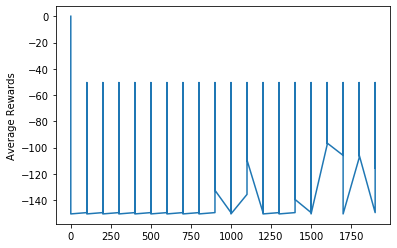

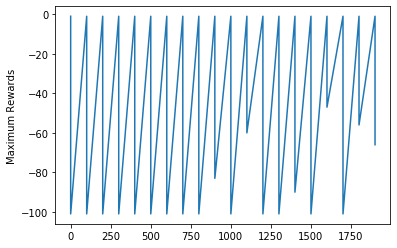

In [14]:
env = gym.make("MountainCar-v0")
alpha = 0.1
gamma = 0.95
episodes = 2000
SHOW_EVERY = 100
STATS_EVERY=100
observation_space_discretesize = [20, 20] # Values of the states [ , ] are called observation space.convert continuous values to discrete values to avoid granularity
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/observation_space_discretesize

# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = episodes//2  # We use "//" for division, so the will be integer.
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)


# Initialize q table with q value -2 and high with 0. Size is 20*20*3. 20*20 is for state and 3 is for actions.
# So row of the q table is the combination of 20*20 states and column has the 3 action

q_table = np.random.uniform(low=-2, high=0, size=(observation_space_discretesize + [env.action_space.n]))

# For statistics
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

def get_discrete_state(state): # get_discrete_state function will convert our environment state which contains continuous values to discrete.
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size # value of states is now between 20 to 0.
    return tuple(discrete_state.astype(np.int))  # This tuple to look up the 3 Q values for the available actions in the q-table

for episode in range(episodes):
    episode_reward = 0
    if episode % SHOW_EVERY == 0:
        render = True
        #print(episode)
    else:
        render = False

    # whether or not the environment is done 
    
    discrete_state= get_discrete_state(env.reset())
    done = False
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state]) # Get action from Q table which gives the maximum q value
        else:
            action = np.random.randint(0, env.action_space.n) # Get random action
        
        new_state, reward, done, _ = env.step(action)
        episode_reward += reward      
        new_discrete_state = get_discrete_state(new_state)
       # if episode % SHOW_EVERY == 0:
       #     env.render()
       
        # If simulation did not end yet(did no reach goal) - update Q table ( for our ebv may be this condition not needed)
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = current_q + alpha * (reward + gamma * max_future_q - current_q )

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value
        
    
        ep_rewards.append(episode_reward)
        if not episode % STATS_EVERY:
            average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
            aggr_ep_rewards['ep'].append(episode)
            aggr_ep_rewards['avg'].append(average_reward)
            aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
            aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
            #print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

        
env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'])
plt.ylabel("Average Rewards")
plt.show()
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'])
plt.ylabel("Maximum Rewards")
plt.show()
